### Домашка 12. Применение нейронных сетей в обучении с подкреплением

In [1]:
import gym
import numpy as np
import torch
from torch.autograd import Variable
from torch.nn.utils import clip_grad_value_
from time import sleep
import matplotlib.pyplot as plt

#Скользящее среднее
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    result = np.concatenate([ret[:n-1] / (np.arange(n-1) + 1)  , ret[n-1:] / n])
    return result

In [2]:
def show_agent_play(env_name, agent, eps):
    '''
    Визуализация поведения в gym среде с названием env_name 
    агента agent по эпсилон-жадной стратегии с заданным eps.
    Функция возвращает сумарный reward показанного эпизода.
    '''
    env = gym.make(env_name)
    env._max_episode_steps = 1000
    s = env.reset()
    env.render()
    sleep(2)
    done = False
    episode_reward = 0
    while done != True:
        a = agent.get_action(s, epsilon=eps)
        s2, r, done, info = env.step(a)
        episode_reward += r
        env.render()
        s = s2
        sleep(0.02)
    env.close()
    return episode_reward

Домашнее задание.
* Добиться успеха в CartPole-v0 при reward_success_threshold = 700 (**2 балла**)
*  [Acrobot-v1](https://gym.openai.com/envs/Acrobot-v1/) до скора -120 (**3 балла**)

Если хочется нырнуть поглубже, то можно попробовать посадить [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/) (**3 балла**) или поиграть в [Atari](https://gym.openai.com/envs/#atari) - там для каждой из игр есть версия где нужно учиться по картинке и версия где нужно учиться по реестровым численным данным приставки. Но для этих сред понадобятся библиотеки box2d-py и atari-py, с которыми все будет хорошо под unixовыми системами, а вот под виндой придется плясать с бубном.

# Решение

### 1. CartPole-v0
- gamma 0.95
- alpha 0.001
- два скрытых слоя 24

In [3]:
class QLearningAgent:
    
    def __init__(self, state_dim, action_dim, hidden_sizes = [16,32], gamma = 1, alpha = 0.1, 
                 epsilon = 0.5, buffer_size = 10**5, batch_size = 2**10, min_epsilon = 0.05):
        
        self.nn  = torch.nn.Sequential()
        cur_dim = state_dim
        for i,hid_dim in enumerate(hidden_sizes):
            self.nn.add_module(f'Linear_{i}',torch.nn.Linear(cur_dim,hid_dim))
            self.nn.add_module(f'Relu_{i}',torch.nn.ReLU())
            cur_dim = hid_dim
        self.nn.add_module('out',torch.nn.Linear(cur_dim,action_dim))

        
        self.optim = torch.optim.Adam(self.nn.parameters(), lr = alpha)
        self.gamma = gamma
        self.epsilon = epsilon
        self.buffer = []
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.action_dim = action_dim
        self.min_epsilon = min_epsilon
        
    def get_action(self, state, epsilon = None):
        '''
        Make action on state. Explore with epsilon rate
        '''
        if not epsilon:
            epsilon =  self.epsilon
        if np.random.rand() < epsilon:
            action = np.random.choice(self.action_dim)
        else:
            q_values = self.nn(Variable(torch.Tensor(state)))        
            action = q_values.argmax().data.numpy().item()
           
        return action
    
    def decrease_exploration_rate(self, decay):
        self.epsilon = max(self.epsilon*decay, self.min_epsilon)
        
    def update_buffer(self,data):
        assert all(len(e)==5 for e in data), 'Buffer accepts only lists of (s,a,r,s1,d) tuples'
        self.buffer = (self.buffer + data)[-self.buffer_size:]
    
    def sample_from_buffer(self, size):
        idx = np.random.choice(len(self.buffer),size,replace = False)
        return [self.buffer[i] for i in idx]
    
    def train_step(self):
        ''' 
        Make agent train step
        '''
        batch = self.sample_from_buffer(self.batch_size)
        sn      = Variable(torch.Tensor([r[0] for r in batch]))  # States batch
        an      = torch.LongTensor([[r[1]] for r in batch])      # Actions batch
        rn      = torch.Tensor([r[2] for r in batch])            # Rewards batch
        s_nextn = Variable(torch.Tensor([r[3] for r in batch]))  # Next states batch
        done = torch.Tensor([float(r[4]) for r in batch]) # Next state is not terminal flag batch
        
        # Mask from actions to apply on model output
        a_maskn = torch.zeros(self.batch_size,self.action_dim).scatter_(1, an, 1).byte()  
        max_next_q_valn = (self.nn(s_nextn)).max(dim=1)[0].data  # max target q-values for next states
        q_valn =  self.nn(sn)  # work nn q-values for curr states
        loss = ((q_valn[a_maskn] - Variable(rn + self.gamma * max_next_q_valn * (1 - done)))**2).mean()
        # Train nn
        self.nn.zero_grad()
        loss.backward()
        clip_grad_value_(self.nn.parameters(),10**5)
        self.optim.step()

In [4]:
gamma = 0.95
alpha = 0.001 # Скорость обучения агента
hidden_sizes = [24, 24] # Количество нейронов в скрытом слое
batch_size = 1000 # Размер батча для обучения
buffer_size = 5*10**5 # Размер буфера для обучения
init_epsilon = 1.0
exploration_decay = 0.995 # Снижение epsilon на каждом шаге
reward_success_threshold = 700
min_epsilon = 0.01

In [5]:
env = gym.make('CartPole-v0').env

rewards_log, counters_log = [], []

agent = QLearningAgent(state_dim = env.observation_space.shape[0],
                       action_dim = env.action_space.n, 
                       hidden_sizes = hidden_sizes, 
                       gamma = gamma, 
                       alpha = alpha, 
                       epsilon = init_epsilon, 
                       buffer_size = buffer_size,
                       batch_size = batch_size,
                       min_epsilon = min_epsilon)

for episode in range(1,1000):
    done = False
    total_reward, counter = 0,0
    state = env.reset()
    #state = tuple([int(i) for i in state])
    while done != True:
         
        action = agent.get_action(state)
        
        # делаем шаг
        next_state, reward, done, info = env.step(action)
        agent.update_buffer([(state,action,reward,next_state,done)])
        
        if len(agent.buffer)>agent.batch_size:
            agent.train_step()
                    
        total_reward += reward
        counter += 1
        state = next_state   
        
    agent.decrease_exploration_rate(exploration_decay)
    
    if episode % 25 == 0:
        print(f'Episode {episode:5d}. Epsilon {agent.epsilon:.3f}. Game reward: {int(total_reward):2d}  step_counter: {counter}. Running reward {np.mean(rewards_log[-50:]):.2f}.')
        
    rewards_log.append(total_reward)
    counters_log.append(counter)
    
    if (np.mean(rewards_log[-10:])>reward_success_threshold):
        print('\nSuccess. We learnt the game with ' +  str(reward_success_threshold) + ' reward threshold.')
        break

Episode    25. Epsilon 0.882. Game reward: 14  step_counter: 14. Running reward 18.21.
Episode    50. Epsilon 0.778. Game reward: 15  step_counter: 15. Running reward 17.59.
Episode    75. Epsilon 0.687. Game reward:  8  step_counter: 8. Running reward 16.42.
Episode   100. Epsilon 0.606. Game reward: 26  step_counter: 26. Running reward 20.60.
Episode   125. Epsilon 0.534. Game reward: 80  step_counter: 80. Running reward 45.76.
Episode   150. Epsilon 0.471. Game reward: 13  step_counter: 13. Running reward 91.52.
Episode   175. Epsilon 0.416. Game reward: 47  step_counter: 47. Running reward 126.72.
Episode   200. Epsilon 0.367. Game reward: 27  step_counter: 27. Running reward 116.48.
Episode   225. Epsilon 0.324. Game reward: 239  step_counter: 239. Running reward 125.62.
Episode   250. Epsilon 0.286. Game reward: 38  step_counter: 38. Running reward 119.40.
Episode   275. Epsilon 0.252. Game reward: 307  step_counter: 307. Running reward 117.50.
Episode   300. Epsilon 0.222. Game 

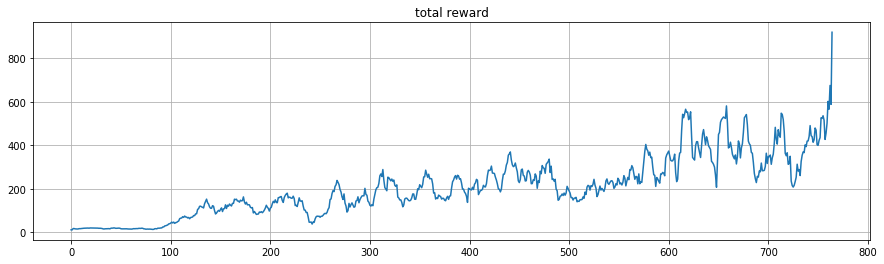

In [6]:
%matplotlib inline
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
axs.plot(moving_average(rewards_log))
axs.set_title('total reward')
plt.grid(True)
plt.show()

In [7]:
#print(f"Reward in eval mode {show_agent_play('CartPole-v0',agent,0)}")

In [8]:
rewards_log[-10:]

[149.0, 95.0, 278.0, 436.0, 796.0, 1302.0, 266.0, 1971.0, 332.0, 3575.0]

### Вывод
- Я смотрел разные подходы: больше слоев, sigmoid, меньше exploration
- Они иногда давали результат, но он не был стабилен и мог как сойтись, так и нет при разных запусках и на разных шагах
- Данный подход дал стабильный рост к 700, но, получается, смотреть среднее по последним 10 - не гарантия качества
- Так как в eval mode можем получить результат иногда меньше
- Если усреднять по большему числу значений, то результат в eval будет лучше
- То есть для хорошей модели, как я понял отсюда, следует в дальнейшем брать среднее по большему числу шагов
- Или как-нибудь иначе

### 2. Acrobot-v1
- Два скрытых слоя 64, 32
- reward_success_threshold = -90 поставил
- если не сойдется, точно сойдется к -95
- (В задании лучше, чем -120 надо сделать)

In [9]:
class QLearningAgent:
    
    def __init__(self, state_dim, action_dim, hidden_sizes = [16,32], gamma = 1, alpha = 0.1, 
                 epsilon = 0.5, buffer_size = 10**5, batch_size = 2**10, min_epsilon = 0.05):
        
        self.nn  = torch.nn.Sequential()
        cur_dim = state_dim
        for i,hid_dim in enumerate(hidden_sizes):
            self.nn.add_module(f'Linear_{i}',torch.nn.Linear(cur_dim,hid_dim))
            self.nn.add_module(f'Relu_{i}',torch.nn.ReLU())
            cur_dim = hid_dim
        self.nn.add_module('out',torch.nn.Linear(cur_dim,action_dim))

        
        self.optim = torch.optim.SGD(self.nn.parameters(), lr = alpha)
        self.gamma = gamma
        self.epsilon = epsilon
        self.buffer = []
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.action_dim = action_dim
        self.min_epsilon = min_epsilon
        
    def get_action(self, state, epsilon = None):
        '''
        Make action on state. Explore with epsilon rate
        '''
        if not epsilon:
            epsilon =  self.epsilon
        if np.random.rand() < epsilon:
            action = np.random.choice(self.action_dim)
        else:
            q_values = self.nn(Variable(torch.Tensor(state)))        
            action = q_values.argmax().data.numpy().item()
           
        return action
    
    def decrease_exploration_rate(self, decay):
        self.epsilon = max(self.epsilon*decay, self.min_epsilon)
        
    def update_buffer(self,data):
        assert all(len(e)==5 for e in data), 'Buffer accepts only lists of (s,a,r,s1,d) tuples'
        self.buffer = (self.buffer + data)[-self.buffer_size:]
    
    def sample_from_buffer(self, size):
        idx = np.random.choice(len(self.buffer),size,replace = False)
        return [self.buffer[i] for i in idx]
    
    def train_step(self):
        ''' 
        Make agent train step
        '''
        batch = self.sample_from_buffer(self.batch_size)
        sn      = Variable(torch.Tensor([r[0] for r in batch]))  # States batch
        an      = torch.LongTensor([[r[1]] for r in batch])      # Actions batch
        rn      = torch.Tensor([r[2] for r in batch])            # Rewards batch
        s_nextn = Variable(torch.Tensor([r[3] for r in batch]))  # Next states batch
        done = torch.Tensor([float(r[4]) for r in batch]) # Next state is not terminal flag batch
        
        # Mask from actions to apply on model output
        a_maskn = torch.zeros(self.batch_size,self.action_dim).scatter_(1, an, 1).byte()  
        max_next_q_valn = (self.nn(s_nextn)).max(dim=1)[0].data  # max target q-values for next states
        q_valn =  self.nn(sn)  # work nn q-values for curr states
        loss = ((q_valn[a_maskn] - Variable(rn + self.gamma * max_next_q_valn * (1 - done)))**2).mean()
        # Train nn
        self.nn.zero_grad()
        loss.backward()
        clip_grad_value_(self.nn.parameters(),10**5)
        self.optim.step()

In [10]:
gamma = 0.99
alpha = 0.01 # Скорость обучения агента
hidden_sizes = [64,32] # Количество нейронов в скрытом слое
batch_size = 1000 # Размер батча для обучения
buffer_size = 5*10**5 # Размер буфера для обучения
init_epsilon = 0.5
exploration_decay = 0.99 # Снижение epsilon на каждом шаге

#Поставить reward_success_threshold = -95, если вдруг не сошлось---
reward_success_threshold = -90
#------------------------------------------------------------------

min_epsilon = 0.05

In [11]:
env = gym.make('Acrobot-v1').env

rewards_log, counters_log = [], []

agent = QLearningAgent(state_dim = env.observation_space.shape[0],
                       action_dim = env.action_space.n, 
                       hidden_sizes = hidden_sizes, 
                       gamma = gamma, 
                       alpha = alpha, 
                       epsilon = init_epsilon, 
                       buffer_size = buffer_size,
                       batch_size = batch_size,
                       min_epsilon = min_epsilon)

for episode in range(1,1000):
    done = False
    total_reward, counter = 0,0
    state = env.reset()
    #state = tuple([int(i) for i in state])
    while done != True:
         
        action = agent.get_action(state)
        
        # делаем шаг
        next_state, reward, done, info = env.step(action)
        agent.update_buffer([(state,action,reward,next_state,done)])
        
        if len(agent.buffer)>agent.batch_size:
            agent.train_step()
                    
        total_reward += reward
        counter += 1
        state = next_state   
        
    agent.decrease_exploration_rate(exploration_decay)
    
    if episode % 25 == 0:
        print(f'Episode {episode:5d}. Epsilon {agent.epsilon:.3f}. Game reward: {int(total_reward):2d}  step_counter: {counter}. Running reward {np.mean(rewards_log[-50:]):.2f}.')
        
    rewards_log.append(total_reward)
    counters_log.append(counter)
    
    if (np.mean(rewards_log[-10:])>reward_success_threshold):
        print('\nSuccess. We learnt the game with ' +  str(reward_success_threshold) + ' reward threshold.')
        break

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode    25. Epsilon 0.389. Game reward: -171  step_counter: 172. Running reward -238.83.
Episode    50. Epsilon 0.303. Game reward: -92  step_counter: 93. Running reward -184.80.
Episode    75. Epsilon 0.235. Game reward: -122  step_counter: 123. Running reward -125.10.
Episode   100. Epsilon 0.183. Game reward: -119  step_counter: 120. Running reward -116.00.
Episode   125. Epsilon 0.142. Game reward: -109  step_counter: 110. Running reward -110.42.
Episode   150. Epsilon 0.111. Game reward: -96  step_counter: 97. Running reward -101.64.

Success. We learnt the game with -90 reward threshold.


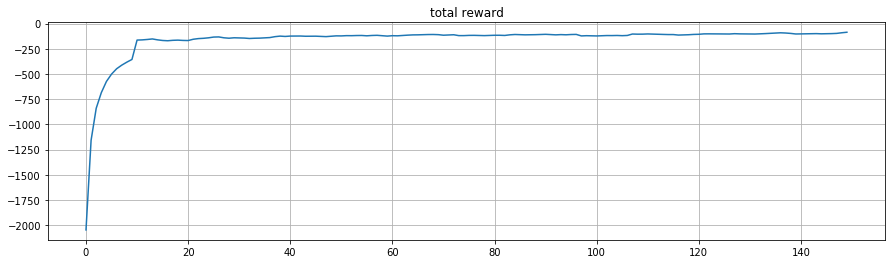

In [12]:
%matplotlib inline
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
axs.plot(moving_average(rewards_log))
axs.set_title('total reward')
plt.grid(True)
plt.show()

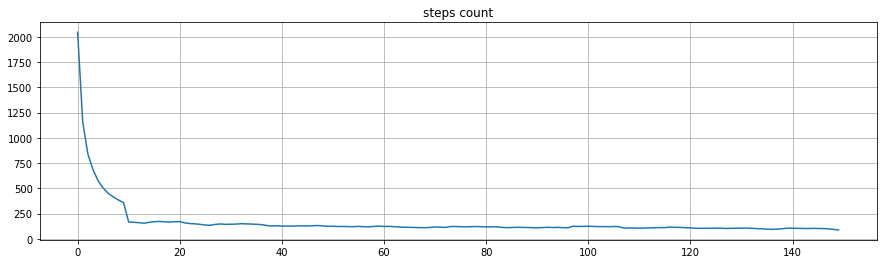

In [13]:
%matplotlib inline
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
axs.plot(moving_average(counters_log))
axs.set_title('steps count')
plt.grid(True)
plt.show()

In [14]:
#print(f"Reward in eval mode {show_agent_play('Acrobot-v1',agent,0)}")

In [15]:
rewards_log[-10:]

[-95.0, -86.0, -72.0, -83.0, -100.0, -78.0, -87.0, -85.0, -81.0, -96.0]

### Вывод
- Дойти до -120 не составляет труда
- Сложно дойти до -70 и далее, тут уже следует возиться немного серьезнее

### 3. LunarLander-v2
- 1. Попытки на основе ReLU, Sigmoid и тд
- (Иногда сходится хотя бы к -100, это явно не решение)
- 2. Tutorial по deep reinforcement learning от Udacity
- (Deep Double Q-Learning)

In [16]:
import Box2D

### 1.

In [17]:
gamma = 0.99
alpha = 0.01 # Скорость обучения агента
hidden_sizes = [400, 400] # Количество нейронов в скрытом слое
batch_size = 1000 # Размер батча для обучения
buffer_size = 5*10**5 # Размер буфера для обучения
init_epsilon = 0.9
exploration_decay = 0.99 # Снижение epsilon на каждом шаге
reward_success_threshold = -100
min_epsilon = 0.3

In [18]:
env = gym.make('LunarLander-v2').env

rewards_log, counters_log = [], []

agent = QLearningAgent(state_dim = env.observation_space.shape[0],
                       action_dim = env.action_space.n, 
                       hidden_sizes = hidden_sizes, 
                       gamma = gamma, 
                       alpha = alpha, 
                       epsilon = init_epsilon, 
                       buffer_size = buffer_size,
                       batch_size = batch_size,
                       min_epsilon = min_epsilon)

for episode in range(1,200):
    done = False
    total_reward, counter = 0,0
    state = env.reset()
    #state = tuple([int(i) for i in state])
    while done != True:
         
        action = agent.get_action(state)
        
        # делаем шаг
        next_state, reward, done, info = env.step(action)
        agent.update_buffer([(state,action,reward,next_state,done)])
        
        if len(agent.buffer)>agent.batch_size:
            agent.train_step()
                    
        total_reward += reward
        counter += 1
        state = next_state   
        
    agent.decrease_exploration_rate(exploration_decay)
    
    if episode % 25 == 0:
        print(f'Episode {episode:5d}. Epsilon {agent.epsilon:.3f}. Game reward: {int(total_reward):2d}  step_counter: {counter}. Running reward {np.mean(rewards_log[-50:]):.2f}.')
        
    rewards_log.append(total_reward)
    counters_log.append(counter)
    
    if (np.mean(rewards_log[-10:])>reward_success_threshold):
        print('\nSuccess. We learnt the game with ' +  str(reward_success_threshold) + ' reward threshold.')
        break

Episode    25. Epsilon 0.700. Game reward: -342  step_counter: 154. Running reward -267.71.
Episode    50. Epsilon 0.545. Game reward: -430  step_counter: 82. Running reward -306.13.
Episode    75. Epsilon 0.424. Game reward: -415  step_counter: 127. Running reward -391.96.
Episode   100. Epsilon 0.329. Game reward: -535  step_counter: 123. Running reward -456.79.
Episode   125. Epsilon 0.300. Game reward: -536  step_counter: 145. Running reward -491.69.
Episode   150. Epsilon 0.300. Game reward: -406  step_counter: 127. Running reward -517.89.
Episode   175. Epsilon 0.300. Game reward: -409  step_counter: 66. Running reward -510.61.


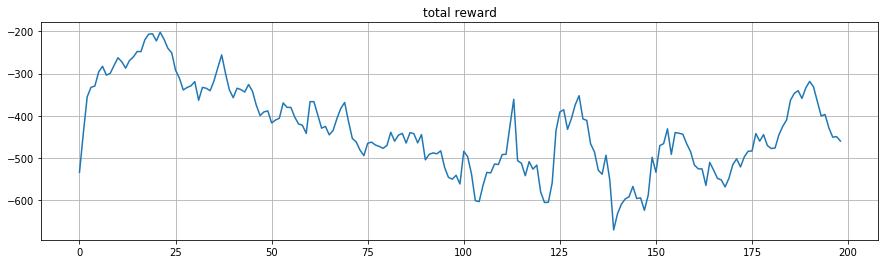

In [19]:
%matplotlib inline
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
axs.plot(moving_average(rewards_log))
axs.set_title('total reward')
plt.grid(True)
plt.show()

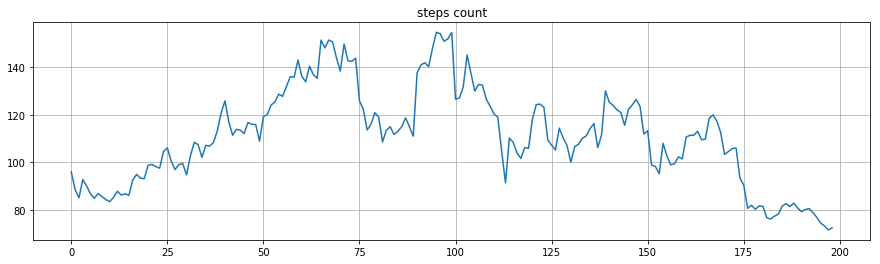

In [20]:
%matplotlib inline
fig, axs = plt.subplots(1, 1, figsize=(15, 4))
axs.plot(moving_average(counters_log))
axs.set_title('steps count')
plt.grid(True)
plt.show()

In [21]:
#print(f"Reward in eval mode {show_agent_play('LunarLander-v2',agent,0)}")

In [22]:
rewards_log[-10:]

[-392.10585360054904,
 -418.35718220703495,
 -482.36722678116087,
 -582.2271450690275,
 -392.7451033369465,
 -221.57549537002666,
 -330.97986484360297,
 -365.9751490707037,
 -565.0009995316545,
 -849.4251827542535]

### 2.

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_size = 64, fc2_size = 64):
        
        super(QNetwork, self).__init__()
        hidden_size = 30
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.out = nn.Linear(fc2_size, action_size)

    def forward(self, state):

        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        action = self.out(x)
        return action
    
class DuelingQNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_size = 64, fc2_size = 64):
        
        super(DuelingQNetwork, self).__init__()
        self.num_actions = action_size
        fc3_1_size = fc3_2_size = 32
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)

        self.fc3_1 = nn.Linear(fc2_size, fc3_1_size)
        self.fc4_1 = nn.Linear(fc3_1_size, 1)

        self.fc3_2 = nn.Linear(fc2_size, fc3_2_size)
        self.fc4_2 = nn.Linear(fc3_2_size, action_size)



    def forward(self, state):
        
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        val = F.relu(self.fc3_1(x))
        val = self.fc4_1(val)
        
        adv = F.relu(self.fc3_2(x))
        adv = self.fc4_2(adv)
        action = val + adv - adv.mean(1).unsqueeze(1).expand(state.size(0), self.num_actions)
        return action

In [24]:
import numpy as np
import random
from collections import namedtuple, deque
import torch.optim as optim

BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 5e-4
UPDATE_EVERY = 4

device = torch.device("cpu")

class Agent():

    def __init__(self, state_size, action_size, seed):

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.qnetwork_local = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):

        self.memory.add(state, action, reward, next_state, done)

        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn_DDQN(experiences, GAMMA)

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):

        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)  
        
       
    def learn_DDQN(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        Q_argmax = self.qnetwork_local(next_states).detach()
        _, a_prime = Q_argmax.max(1)
        Q_targets_next = self.qnetwork_target(next_states).detach().gather(1, a_prime.unsqueeze(1))
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)  

    def soft_update(self, local_model, target_model, tau):

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [25]:
from IPython import display

In [26]:
env = gym.make('LunarLander-v2').env
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


Episode 100	Average Score: -220.87
Episode 200	Average Score: -150.69
Episode 300	Average Score: -34.331
Episode 400	Average Score: 24.960
Episode 423	Average Score: 42.27
Environment solved in 323 episodes!	Average Score: 42.27


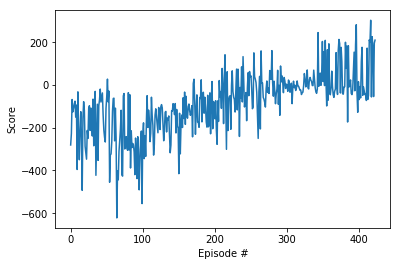

In [27]:
agent = Agent(state_size=8, action_size=4, seed=0)

def train(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        #Поставил 40, чтобы долго не считать
        #Посадить можно, поставив 100, 150
        if np.mean(scores_window)>=40.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_Dueling_DDQN.pth')
            break
    return scores

scores = train()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

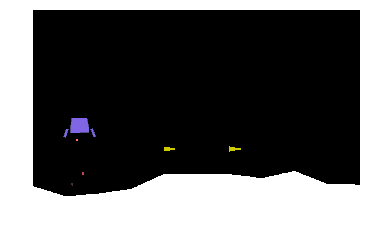

In [28]:
agent = Agent(state_size=8, action_size=4, seed=0)

agent.qnetwork_local.load_state_dict(torch.load('checkpoint_Dueling_DDQN.pth', map_location=lambda storage, loc: storage))

for i in range(3):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(200):
        action = agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

### Вывод
- Тут действительно нужно было "нырнуть поглубже"